In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

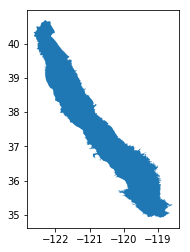

In [2]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
cv.plot()

In [27]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis_aet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]
data['modis_pet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "PET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_NTSG_MOD16A2_105
data['modis_aet2'] = [ee.ImageCollection("MODIS/NTSG/MOD16A2/105"), "ET", 0.1]
data['modis_pet2'] = [ee.ImageCollection("MODIS/NTSG/MOD16A2/105"), "PET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 1] # 86400*30

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 86400*30]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['tc_aet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]
data['tc_pet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "pet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*30]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

###################
##### SWE data #####
####################
data['swe'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "SWE_inst", 1 ]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

#####################
##### SM data #######
#####################

data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]

data['sm1'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 1]
data['sm2'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 1]
data['sm3'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 1]
data['sm4'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 1]

In [24]:
def get_data(dataset, year, month, area):
    '''
    calculates the monthly sum a dataset in units of mm/time 
    '''

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var]
    
    return result

def wrapper(dataset):
    
    '''
    Wrapper for `get_data` that takes a dataset and an area
    '''
    monthly = []

    for year in years:
        print(year)
        for month in months:
            r = get_data(dataset, year, month, area)
            monthly.append(r)
            time.sleep(5)
    
    print("wrapper complete")
    return monthly

def gen_polys(geometry, dx=0.5, dy=0.5):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results



In [25]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [26]:
# ET
fldas = wrapper(data['fldas'])
modis_pet = wrapper(data['modis_pet'])
modis_aet = wrapper(data['modis_aet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


KeyError: 'tc_aet'

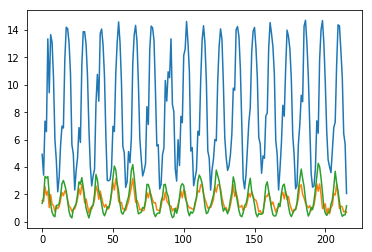

In [30]:
plt.plot(modis_pet)
plt.plot(modis_aet)
plt.plot(fldas)

In [31]:
tc_aet = wrapper(data['tc_aet'])
tc_pet = wrapper(data['tc_pet'])
modis_pet2 = wrapper(data['modis_pet2'])
modis_aet2 = wrapper(data['modis_aet2'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


EEException: Image.multiply: If one image has no bands, the other must also have no bands. Got 0 and 1.

In [ ]:
# Terracliamte Potential ET 
tcpet = wrapper(data['tc_pet'])

In [ ]:
# Fldas ET 
et_f = wrapper(data['fldas'])

In [ ]:
# GLDAS ET 
et_g = wrapper(data['gldas'])

In [10]:
# Fetch Soil Moisture and swe - warning: takes some time

sm = wrapper(data['sm'])
swe = wrapper(data['swe'])

wrapper complete
wrapper complete


In [14]:
# runoff
r = wrapper(data['r'])

wrapper complete


In [15]:
# Fetch all ET data - warning: takes very long
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])
# TODO: gldas, nldas

wrapper complete
wrapper complete
wrapper complete
wrapper complete
wrapper complete


In [ ]:
# Fetch all precip data - warning: takes very long
p_p = wrapper(data['prism'])
p_c = wrapper(data['chirps'])
p_n = wrapper(data['persia'])
p_t = wrapper(data['trmm'])
p_d = wrapper(data['dmet'])

In [10]:
# Stack P and ET datasets and calc mean
p_arrs = [np.array(x) for x in [p_p, p_c, p_n, p_t, p_d]]
p_stacked = np.column_stack(p_arrs)
p = np.mean(p_stacked, axis = 1)

et_arrs = [np.array(x) for x in [et_m, eto_g, etr_g, et_f, et_t]]
et_stacked = np.column_stack(et_arrs)
et = np.mean(et_stacked, axis = 1)

In [11]:
# Read c2vsim storage data

data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".txt")]

ds = pd.read_csv(files[0], sep='\t', header=0)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

# remove local timezone
ds = ds.tz_localize(None).copy()
ds.drop(["dt", "region"],axis = 1, inplace = True)
ds['s'] = ds['s'] * 1.23348 # MAF to km^3

# Read USGS Reservoir data
res_s = pd.read_csv("../data/reservoir_storage.csv")
res_s.set_index(res_s.columns[0], inplace = True)
res_s.index = pd.to_datetime(res_s.index)
res_s.index.name = "date"

# Read Streamflow IN data (Note that CA Aqueduct is accounted for here)
Qs_in = pd.read_csv("../data/Qs_in_monthly.csv", header = None)
Qs_in.set_index(Qs_in.columns[0], inplace = True)
Qs_in.index = pd.to_datetime(Qs_in.index)
Qs_in.index.name = "date"

# Read Streamflow Out data
Qs_out = pd.read_csv("../data/Qs_out_dayflow.csv", header = None)
Qs_out.set_index(Qs_out.columns[0], inplace = True)
Qs_out.index = pd.to_datetime(Qs_out.index)
Qs_out.index.name = "date"

# Calculate the true runoff as SSJT runoff - CV runoff
ssjtr = pd.read_csv("../data/all_data_ssjt.csv")
ssjtr.set_index(ssjtr.columns[0], inplace = True)
ssjtr.index = pd.to_datetime(ssjtr.index)
ssjtr.index.name = "date"
cvr = np.array(ssjtr.runoff.dropna() - r)

In [18]:
# Make a df from precip and ET RS data:

years = range(2001, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

petdf = pd.DataFrame([cvr, sm, p_p, p_c, p_n, p_t,p_d, et_m, eto_g, etr_g, et_f, et_t, list(p),list(et)]).T

petdf.index = dt_idx


In [26]:
df_t1 = pd.merge(petdf,Qs_in, how='inner', left_index=True, right_index=True)
df_t2 = pd.merge(df_t1,Qs_out, how='inner', left_index=True, right_index=True)
df = pd.merge(df_t2,res_s, how='inner', left_index=True, right_index=True)

df.columns = ["runoff", "soil_moisture", "prism", "chirps", 
              "persiann" ,"trmm", "daymet", "modis", "gmet_eto", 
              "gmet_etr", "fldas", "terraclimate", 'p_mean', 'et_mean', 
              "q_in","q_out","res_s"]

df = pd.merge(df,ds, how='outer', left_index=True, right_index=True)

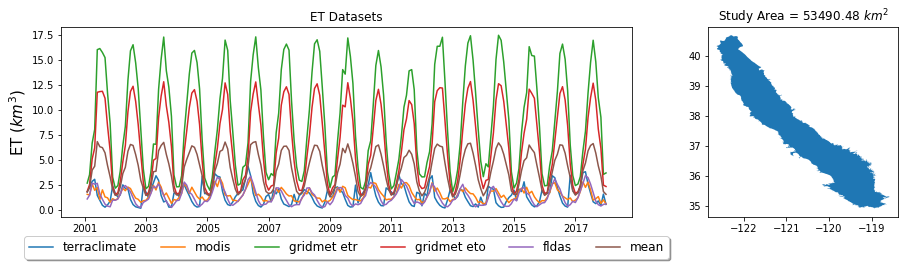

In [27]:
# Plot the ET Datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("ET Datasets")
a0.plot(df.index, df.terraclimate, label = 'terraclimate')
a0.plot(df.index, df.modis, label = "modis")
a0.plot(df.index, df.gmet_etr, label = 'gridmet etr')
a0.plot(df.index, df.gmet_eto, label = 'gridmet eto')
a0.plot(df.index, df.fldas, label = 'fldas')
a0.plot(df.index, df.et_mean, label = 'mean')
a0.set_ylabel('ET $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

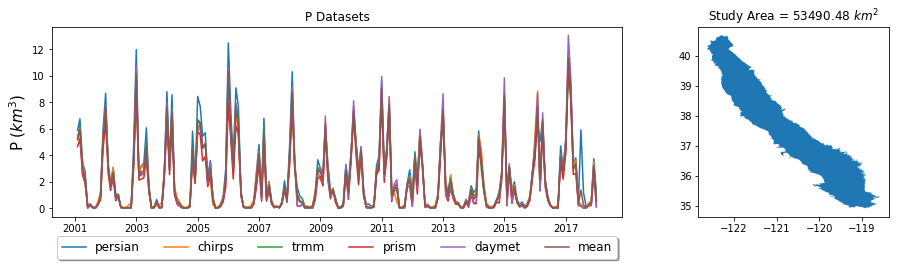

In [28]:
# P datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("P Datasets")

a0.plot(df.index, df.persiann, label = 'persian')
a0.plot(df.index, df.chirps, label = "chirps")
a0.plot(df.index, df.trmm, label = 'trmm')
a0.plot(df.index, df.prism, label = 'prism')
a0.plot(df.index, df.daymet, label = 'daymet')
a0.plot(df.index, df.p_mean, label = 'mean')
a0.set_ylabel('P $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

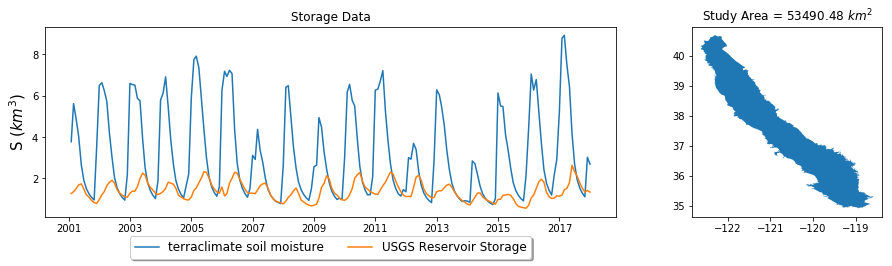

In [29]:
# SM data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Storage Data")

a0.plot(df.index, df.soil_moisture, label = 'terraclimate soil moisture')
a0.plot(df.index, df.res_s, label = 'USGS Reservoir Storage')

a0.set_ylabel('S $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1)

plt.show()

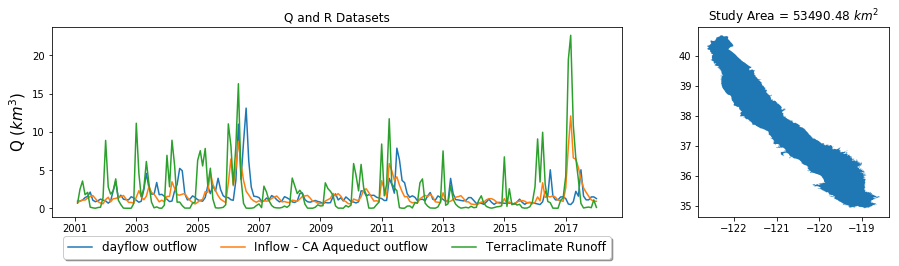

In [30]:
# Q and R data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Q and R Datasets")

a0.plot(df.index, df.q_out, label = 'dayflow outflow')
a0.plot(df.index, df.q_in, label = 'Inflow - CA Aqueduct outflow')
a0.plot(df.index, df.runoff, label = 'Terraclimate Runoff')

a0.set_ylabel('Q $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1)

plt.show()

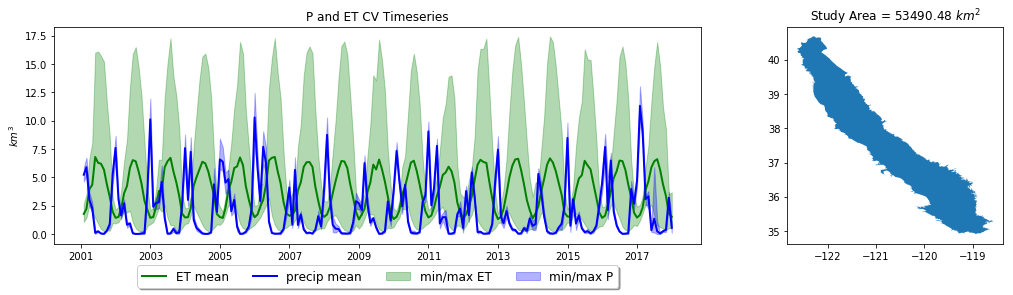

In [31]:
# Plot the means and ranges
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(17,4))

a0.set_title("P and ET CV Timeseries")

a0.plot(dt_idx, et, label = "ET mean", color = "green", linewidth=2.0)
a0.fill_between(dt_idx, np.min(et_stacked, axis = 1), np.max(et_stacked, axis = 1), alpha = 0.3, color = "green", label = "min/max ET")

a0.plot(dt_idx, p, label = "precip mean", color = "blue", linewidth = 2.0)
a0.fill_between(dt_idx, np.min(p_stacked, axis = 1), np.max(p_stacked, axis = 1), alpha = 0.3, color = "blue", label = "min/max P")
a0.set_ylabel("$km^3$")
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

In [37]:
# save the csv
df.to_csv("../data/all_data_cv.csv")

# Calc the balance
df['ds'] = df.p_mean - df.et_mean + df.runoff - df.q_out + df.q_in - df.soil_moisture.diff() - df.res_s.diff()

# Chop off first 30 years of c2vsim and Initialize starting value as the c2vsim starting value
df = df.iloc[327:]
df.ds[0] = df.s[0]

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


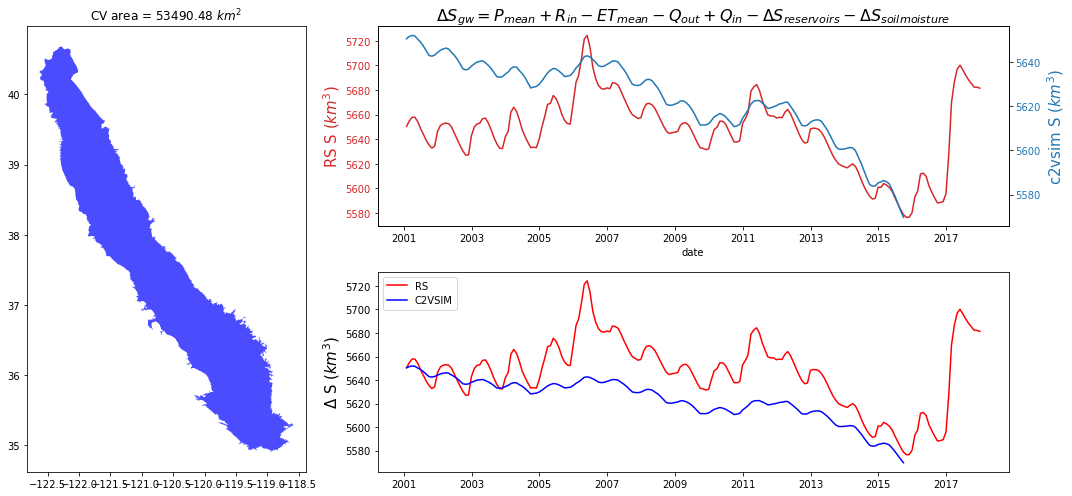

In [38]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("CV area = {} $km^2$ ".format(sa_km3))

# Top right timeseries
axes_2 = plt.subplot(G[0, 1:])
axes_2.set_title("$\Delta S_{gw} = P_{mean} + R_{in} -  ET_{mean} - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

color = 'tab:red'
axes_2.set_xlabel('date')
axes_2.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_2.plot(df.index, np.cumsum(df.ds), color=color)
axes_2.tick_params(axis='y', labelcolor=color)

axes_3 = axes_2.twinx()  

color = 'tab:blue'
axes_3.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15)  
axes_3.plot(df.index, df.s, color=color)
axes_3.tick_params(axis='y', labelcolor=color)

# Bottom right
axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS")
axes_4.plot(df.index, df.s, color="blue", label = "C2VSIM")
axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.tight_layout()
plt.show()

In [51]:
# Compute annual ds sums from ds = P - ET - Q:

ydf = pd.merge(df,ds, how='inner', left_index=True, right_index=True)

years = np.arange(ydf.index[0].year, ydf.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = ydf.iloc[ydf.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = ydf.iloc[ydf.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = ydf.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_y'][-1] - hydro_year_df['s_y'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()

    
dt_y = pd.date_range(start=ydf.index[0], end=ydf.index[-1] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})
ds_df.index = dt_y

# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [52]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


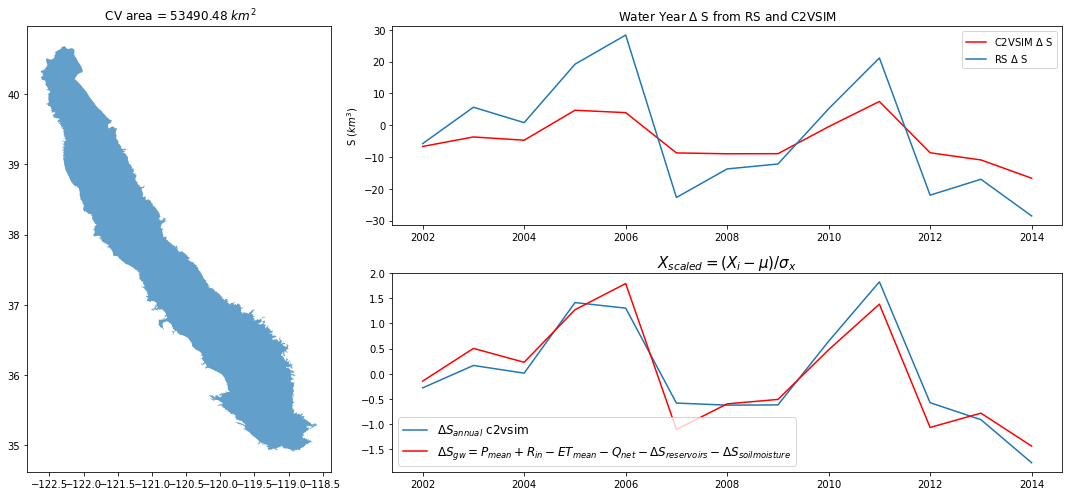

In [72]:
# Plot

plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, alpha = 0.7)
axes_1.set_title(" CV area = {} $km^2$ ".format(sa_km3))

axes_2 = plt.subplot(G[0, 1:])

axes_2.set_title("Water Year $\Delta$ S from RS and C2VSIM")
axes_2.plot(ds_df.index,ds_df.c2vds, color = "red", label = "C2VSIM $\Delta$ S")
axes_2.plot(ds_df.index,ds_df.ds, label = "RS $\Delta$ S")
axes_2.set_ylabel("S $(km^3)$")
axes_2.legend()

axes_3 = plt.subplot(G[1, 1:])
axes_3.set_title("$ X_{scaled} = ({X_i - \mu})/{\sigma_x}$", size = 15)
axes_3.plot(ds_df.index, scaled[1], label = "$\Delta S_{annual}$ c2vsim")
axes_3.plot(ds_df.index, scaled[0], color = "red", label = "$\Delta S_{gw} = P_{mean} + R_{in} -  ET_{mean} - Q_{net} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$")
axes_3.legend(loc="lower left", fontsize = 'large')

plt.tight_layout()
plt.show()

In [625]:
# Run an ensemble varying the ET data used

In [62]:
et_results = []

for i in [endf.modis, endf.gmet_eto, endf.gmet_etr, endf.fldas, endf.terraclimate, endf.et_mean]:
    ds = endf.p_mean - i - endf.q_out + endf.q_in + endf.runoff - endf.soil_moisture.diff() - endf.res_s.diff()

    ds[0] = 0
    et_results.append(ds)
    
results = pd.concat(et_results, axis = 1)
results['avg'] = results.mean(axis = 1)
results['avg'][0] = 0

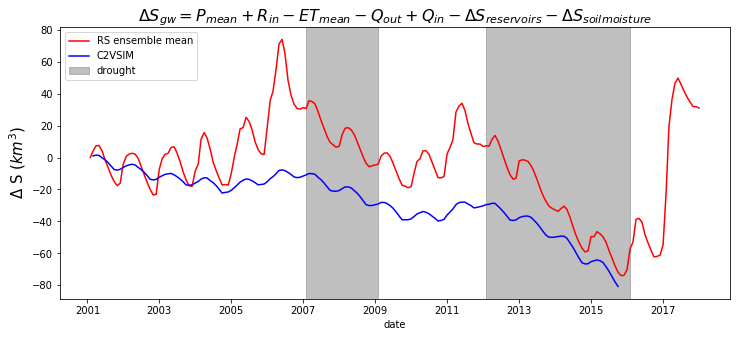

In [66]:
plt.figure(figsize = (12,5))
plt.title("$\Delta S_{gw} = P_{mean} + R_{in} - ET_{mean} - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

plt.plot(results.index, np.cumsum(results.avg), color="red", label = "RS ensemble mean")
plt.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
plt.axvspan(results.index[72], results.index[96], alpha=0.5, color='gray', label = "drought")
plt.axvspan(results.index[132], results.index[180], alpha=0.5, color='gray')
plt.ylabel('$\Delta$ S ($km^3$)', size = 15) 
plt.xlabel('date')
plt.legend()
plt.show()

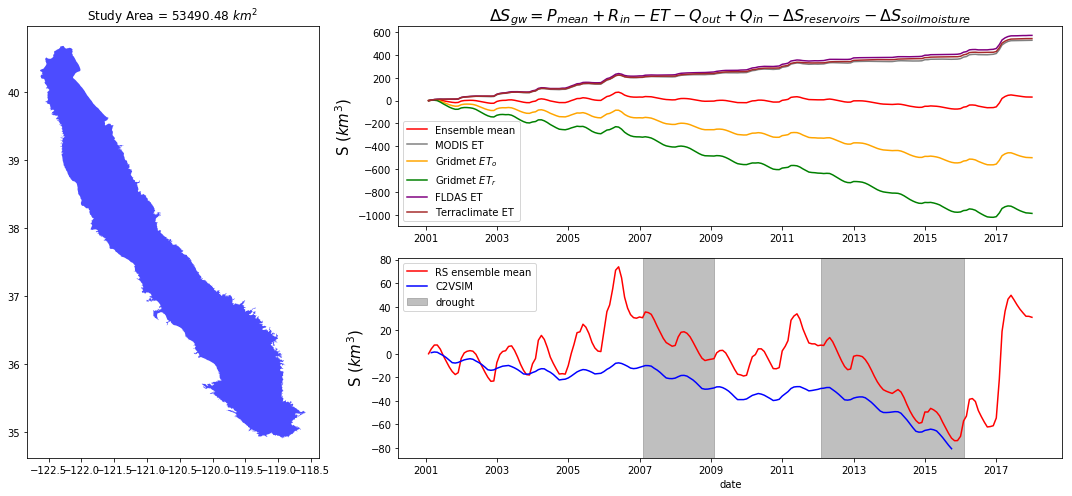

In [67]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("Study Area = {} $km^2$".format(sa_km3))

a0 = plt.subplot(G[0, 1:])
a0.set_title("$\Delta S_{gw} = P_{mean} + R_{in} - ET - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)
a0.plot(results.index, np.cumsum(results.avg), color = "red", label = "Ensemble mean")
a0.plot(results.index, np.cumsum(results[0]), color = "gray", label = "MODIS ET")
a0.plot(results.index, np.cumsum(results[1]), color = "orange", label = "Gridmet $ET_o$")
a0.plot(results.index, np.cumsum(results[2]), color = "green", label = "Gridmet $ET_r$")
a0.plot(results.index, np.cumsum(results[3]), color  = "purple", label = "FLDAS ET")
a0.plot(results.index, np.cumsum(results[4]), color = "brown", label = "Terraclimate ET")
a0.set_ylabel('S ($km^3$)', size = 15) 
a0.legend()

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(results.index, np.cumsum(results.avg), color="red", label = "RS ensemble mean")
axes_4.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.axvspan(results.index[72], results.index[96], alpha=0.5, color='gray', label = "drought")
axes_4.axvspan(results.index[132], results.index[180], alpha=0.5, color='gray')
axes_4.set_ylabel('S ($km^3$)', size = 15) 
axes_4.set_xlabel('date')
axes_4.legend()

plt.tight_layout()
plt.show()